In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division



from keras.regularizers import l2
from keras.engine.topology import get_source_inputs

import keras.backend as KB

import pickle
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import random

import keras as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt
import cv2
from keras.utils.vis_utils import plot_model
from IPython.display import Image, display

from PIL import Image


/home/rajat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class CamVid_Process:
    
    def imread(self , name):
        return cv2.cvtColor(cv2.imread(name) , cv2.COLOR_BGR2RGB)

    def image2class(self , image):
        img = np.zeros((image.shape[0],image.shape[1]))
        for i,t in enumerate(self.color_list):
            img[np.all(image == t[0] , axis = -1)] = i
        return img

    def class2onehot(self , classm):
        return (np.arange(self.nb_classes) == classm[...,None]).astype(np.int8)

    def class2image(self , classm):
        img = np.zeros((classm.shape[0],classm.shape[1],3))
        for i,t in enumerate(self.color_list):
            img[classm == i] = np.array(t[0])
        return img.astype(np.uint8)

    def image_file(self , name):
        return self.images_dir+'/'+name

    def label_file(self , name):
        return self.labels_dir+'/'+name.split('.')[0]+'_'+self.label_suffix+'.png'




    def __init__(self ,images_dir , labels_dir , classes = None):

        '''
        Original Video sampling by cameras was at 30 Hz
        i.e 30 frames per second
        This then turned into a 1Hz sampling for 1 frame
        per second. The sampling is done for getting rid of 
        reptitive frames

        for our experiment we create these kind of data set 
        organisation

        1. frame => label (training segmentation network)
        2. frame => future label (training sgemententation with optical flow)
                    i.e capture future intuition
                    Try with 1second , Try with 2second , Try with 3 second
        3. frame_seq => frame_seq_label (training segmentation sequence model)
        4. frame_seq => future_frame_seq_label (shifted by two or three frames)
        
        using all these the frame vision field can be limited
        '''

        self.color_list =   [           ([0, 0, 0]         ,  'Void'), ## The position is their class so void stays at 0
                                        ([192, 0, 128]     ,  'Archway'),
                                        ([0, 128, 192]     ,  'Bicyclist'),
                                        ([0, 128, 64]      ,  'Bridge'),
                                        ([64, 128, 64]     ,  'Animal'),
                                        ([128, 0, 0]       ,  'Building'),
                                        ([64, 0, 128]      ,  'Car'),
                                        ([64, 0, 192]      ,  'CartLuggagePram'),
                                        ([192, 128, 64]    ,  'Child'),
                                        ([192, 192, 128]   ,  'Column_Pole'),
                                        ([64, 64, 128]     , 'Fence'),
                                        ([128, 0, 192]     , 'LaneMkgsDriv'),
                                        ([192, 0, 64]      , 'LaneMkgsNonDriv'),
                                        ([128, 128, 64]    , 'Misc_Text'),
                                        ([192, 0, 192]     , 'MotorcycleScooter'),
                                        ([128, 64, 64]     , 'OtherMoving'),
                                        ([64, 192, 128]    , 'ParkingBlock'),
                                        ([64, 64, 0]       , 'Pedestrian'),
                                        ([128, 64, 128]    , 'Road'),
                                        ([128, 128, 192]   , 'RoadShoulder'),
                                        ([0, 0, 192]       , 'Sidewalk'),
                                        ([192, 128, 128]   , 'SignSymbol'),
                                        ([128, 128, 128]   , 'Sky'),
                                        ([64, 128, 192]    , 'SUVPickupTruck'),
                                        ([0, 0, 64]        , 'TrafficCone'),
                                        ([0, 64, 64]       , 'TrafficLight'),
                                        ([192, 64, 128]    , 'Train'),
                                        ([128, 128, 0]     , 'Tree'),
                                        ([192, 128, 192]   ,  'Truck_Bus'),
                                        ([64, 0, 64]       ,  'Tunnel'),
                                        ([192, 192, 0]     ,  'VegetationMisc'),
                                        ([64, 192, 0]      ,   'Wall')
                                    ]

        if classes is not None:
            assert(isinstance(classes,list) ) ,"log:give a list of classes, check dataset or code"
            color_list = [self.color_list[0]]
            for t in self.color_list[1:]:
                if t[1] in classes:
                    color_list.append(t)
            self.color_list = color_list

        self.nb_classes  = len(self.color_list)   
        print("log: after filtering there are ",self.nb_classes," classes for training")                          

        self.label_suffix = 'L' ## dataset specific
        self.split_char = '_' ## dataset specific
        image_name_list = os.listdir(images_dir)
        image_name_list.sort()
        labels_name_list = os.listdir(labels_dir)
        
        image_sequence_dict = {}

        for name in image_name_list:
#             print(name)
            n , s = name.split(self.split_char)
            image_sequence_dict.setdefault(n , [])
            image_sequence_dict[n].append(s)

        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_name_list = image_name_list
        self.labels_name_list = labels_name_list
        self.image_sequence_dict = image_sequence_dict

        


    def frame2label_val_datagen(self , size = None  , normalise = True):
        '''
            Using this makes sense when validation is True
        '''
        val_images = self.image_name_list[int(len(self.image_name_list)*0.9):]
        random.shuffle(val_images)
        batch_size = len(val_images)
        itr = len(val_images) // batch_size 
        for i in range(itr+1):
            IMAGES = []
            LABELS = []
            beg = i*batch_size
            end = (i*batch_size + batch_size) if (i*batch_size + batch_size) < len(val_images) else -1
            for img_file in val_images[beg:end]:
                image = self.imread(self.image_file(img_file))
                label = self.image2class(self.imread(self.label_file(img_file)))
                
                if size != None:
                    assert( len(size) == 2) , "log: give (y , x) format size"
                    image = cv2.resize(image , size , interpolation = cv2.INTER_NEAREST)
                    label = cv2.resize(label , size , interpolation = cv2.INTER_NEAREST)    
                label = self.class2onehot(label)
                IMAGES.append(image)
                LABELS.append(label)
            IMAGES = np.array(IMAGES)
            LABELS = np.array(LABELS)
            if normalise:
                IMAGES= IMAGES/255
            yield np.array(IMAGES),np.array(LABELS)        


    def frame2label_train_datagen(self ,size = None  ,  batch_size = 28 , validation = True , normalise = True):
        
        train_images = self.image_name_list
        
        if validation == True:
            train_images = self.image_name_list[:int(len(self.image_name_list)*0.9)]

        random.shuffle(train_images)
        itr = len(train_images) // batch_size 
        for i in range(itr+1):
            IMAGES = []
            LABELS = []
            beg = i*batch_size
            end = (i*batch_size + batch_size) if (i*batch_size + batch_size) < len(train_images) else -1
            for img_file in train_images[beg:end]:
                
                image = self.imread(self.image_file(img_file))
                label = self.image2class(self.imread(self.label_file(img_file)))
                
                if size != None:
                    assert( len(size) == 2) , "log: give (y , x) format size"
                    image = cv2.resize(image , size , interpolation = cv2.INTER_NEAREST)
                    label = cv2.resize(label , size , interpolation = cv2.INTER_NEAREST)    
                label = self.class2onehot(label)
                IMAGES.append(image)
                LABELS.append(label)
            IMAGES = np.array(IMAGES)
            LABELS = np.array(LABELS)
            if normalise:
                IMAGES = IMAGES/255

            yield np.array(IMAGES),np.array(LABELS)

    def jaccard_index(y_pred , y):
        intersection = np.logical_and(y, y_pred)
        union = np.logical_or(y, y_pred)
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score


    def get_class_weights(self , c=1.02):
        _ , labels = next(self.frame2label_train_datagen(size = (256 , 256)  ,  batch_size = len(self.image_name_list) , 
                    validation = False , normalise = False))
        labels = np.argmax(labels , axis = -1)
        print(labels.shape)
        all_labels = labels.flatten()
        each_class = np.bincount(all_labels, minlength=self.nb_classes)
        prospensity_score = each_class / len(all_labels)
        class_weights = 1 / (np.log(c + prospensity_score))
        return class_weights
        
    



    def frame2futurelabel_train_datagen(self , size=None , batch_size = 28 , time_step = 1 , normalise = True):
        assert(batch_size > time_step) ,'log: batch size must be greater than time step'

        for sequence in self.image_sequence_dict.keys():
            train_images = self.image_sequence_dict[sequence]
            itr = len(train_images) // batch_size
            for i in range(itr+1):
                IMAGES = []
                IMAGES_FUTURE = []
                LABELS_FUTURE = []
                beg = i*batch_size
                end = (i*batch_size + batch_size) if (i*batch_size + batch_size) < len(train_images) else -1
                train_batch = self.image_sequence_dict[sequence][beg:end ]
                for i in range(len(train_batch)-time_step):
                    frame1 = self.image_file(self.split_char.join([sequence,train_batch[i]]))
                    frame2 = self.image_file(self.split_char.join([sequence,train_batch[i+time_step]]))
                    label2 = self.label_file(self.split_char.join([sequence,train_batch[i+1]]))
                    frame1_image = self.imread(frame1)
                    frame2_image = self.imread(frame2)
                    label2_classim = self.image2class(self.imread(label2))
                    if size != None:
                        assert( len(size) == 2) , "log: give (y , x) format size"
                        frame1_image = cv2.resize(frame1_image , size , interpolation = cv2.INTER_NEAREST)
                        frame2_image = cv2.resize(frame2_image , size , interpolation = cv2.INTER_NEAREST)
                        label2_classim = cv2.resize(label2_classim , size , interpolation = cv2.INTER_NEAREST)
                    label2_onehote = self.class2onehot(label2_classim)
                    IMAGES.append(frame1_image)
                    IMAGES_FUTURE.append(frame2_image)
                    LABELS_FUTURE.append(label2_onehote)

                IMAGES = np.array(IMAGES)
                IMAGES_FUTURE = np.array(IMAGES_FUTURE)
                LABELS_FUTURE = np.array(LABELS_FUTURE)

                if normalise:
                    IMAGES_FUTURE =IMAGES_FUTURE/255
                    IMAGES = IMAGES/255


                yield IMAGES , IMAGES_FUTURE , LABELS_FUTURE

In [3]:
images = 'images'
labels = 'labels'
proc = CamVid_Process(images , labels , 
                      classes = ['Bicyclist','Car' , 'Animal' , 'Child' , 'MotorcycleScooter' , 'Column_Pole' , 'Pedestrian' , 'Train' , 'Tree' , 'Truck_Bus','Building','Wall', 'TrafficLight','SUVPickupTruck']
                     )
nb_classes = proc.nb_classes 

class_weights = proc.get_class_weights()
print(class_weights)

log: after filtering there are  15  classes for training
(700, 256, 256)
[ 2.12295744 40.08181513 50.37543393  4.51640676 18.99204356 49.80126411
 33.95905987 50.24637627 38.38829549 37.45515853 42.62263947 50.49834979
  8.50530404 39.92328025 30.31732415]


In [4]:
def jaccard_distance(y_true, y_pred, smooth=100):
   
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [5]:
def conv_block(x,nb_filter,dropout_rate):
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Conv2D(nb_filter,(3,3),kernel_initializer='he_uniform',padding='same')(x)
    x=Dropout(dropout_rate)(x)
    return x

def transition_down(x,nb_filter,dropout_rate):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (1, 1),kernel_initializer="he_uniform",padding="same",activation=None)(x)

    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    return x

def transition_up(x,nb_filter):
    
    x = Conv2DTranspose(nb_filter,kernel_size=(3, 3), strides=(2,2),kernel_initializer="he_uniform",padding="same",activation=None)(x)
    return x

def denseblock(x,nb_layers,growth_rate,dropout_rate):
    lists=[x]
    for i in range(nb_layers):
        x=conv_block(x,growth_rate,dropout_rate)
        lists.append(x)
        if i ==  nb_layers - 1:
            x=Concatenate(axis=-1)(lists[1:])
        else:
            x=Concatenate(axis=-1)(lists)
    
    return x,(nb_layers * growth_rate)
    
  
  
def densenet(nb_classes, img_dim,growth_rate , nb_layers = [4,5,7,10,12] ,dropout_rate = 0.2 ,input_size = 48):
    concat_axis=-1
    inputs=Input(shape=img_dim)
    x=Conv2D(filters=input_size,kernel_size=(3,3),kernel_initializer="he_uniform",padding="same")(inputs)
    
    dense_outputs = []
    for nb_layer in nb_layers:
        dense,f = denseblock(x,nb_layers=nb_layer,growth_rate=growth_rate,dropout_rate=dropout_rate)
        x = Concatenate(axis = -1)([x , dense])
        dense_outputs.append(x)
        x = transition_down(x,f+input_size,dropout_rate=dropout_rate)
        input_size = f+input_size
    
    dense,f = denseblock(x,nb_layers=15,growth_rate=growth_rate,dropout_rate=dropout_rate)
    x = Concatenate(axis = -1)([x , dense])
    input_size = f
    
    
    dense_outputs=(dense_outputs)[::-1]
    nb_layers=(nb_layers)[::-1]
    
    for i in range(0,5):
        
        x=transition_up(x,input_size)
        x=Concatenate(axis=-1)([x,dense_outputs[i]])  
        dense,f = denseblock(x,nb_layers=nb_layers[i],growth_rate=growth_rate,dropout_rate=dropout_rate)
        x=Concatenate(axis=-1)([x,dense])
        input_size=f
    
    x=Conv2D(filters=nb_classes,kernel_size=(1,1),kernel_initializer="he_uniform",padding="same",activation= 'softmax')(x)
    
    model=Model(inputs=[inputs],outputs=[x])
#     model.summary()
    model.compile(optimizer = RMSprop(lr = 1e-3), loss = 'categorical_crossentropy', metrics = [jaccard_distance])
    return model
 
#densenet(nb_classes=nb_classes,img_dim=(256,256,3),growth_rate=16)
#densemodel=densenet(nb_classes=11,img_dim=(256,256,3),growth_rate=16)


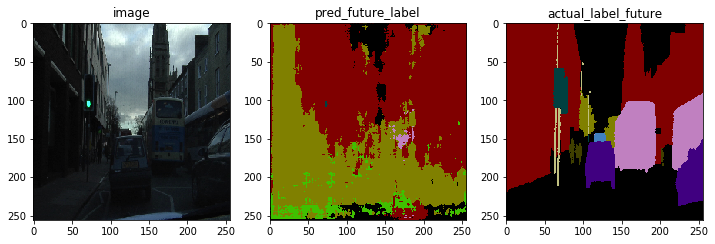

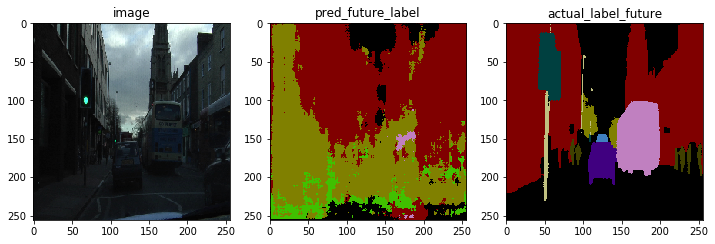

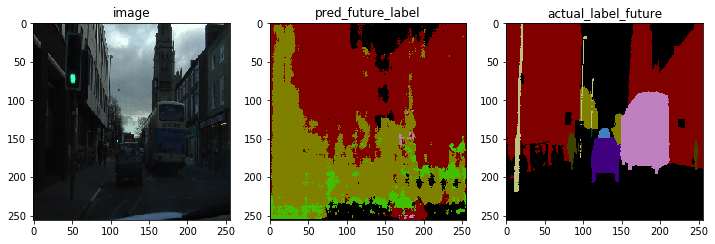

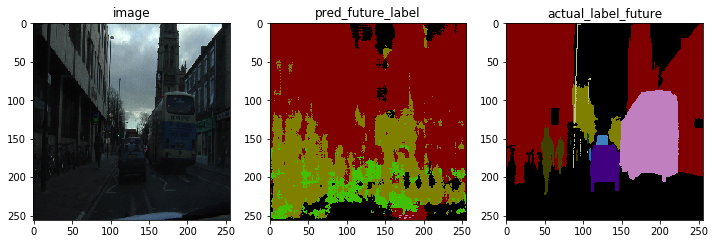

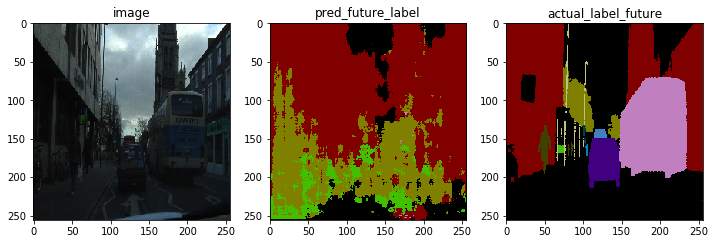

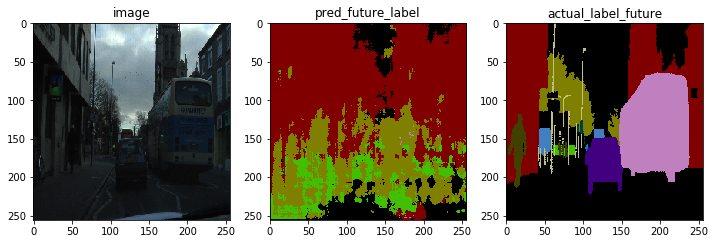

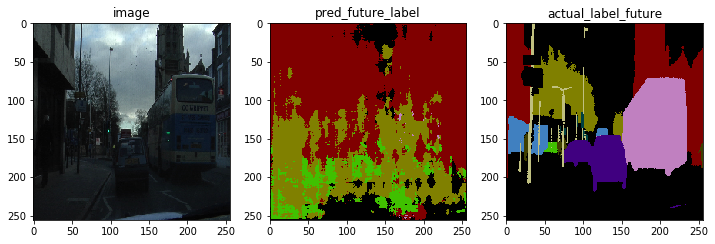

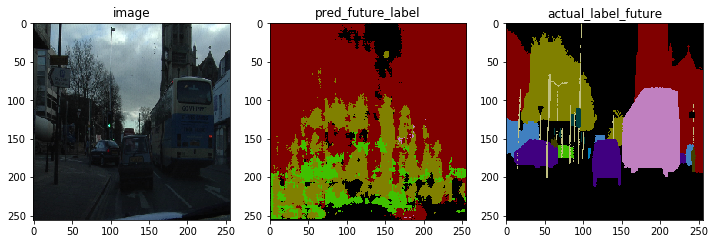

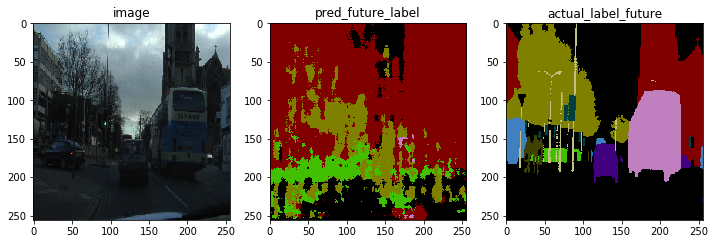

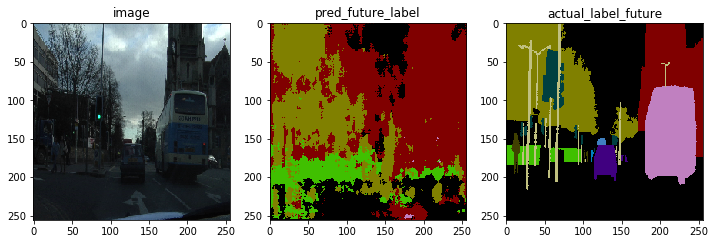

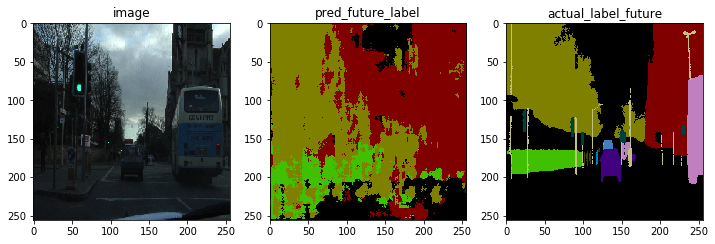

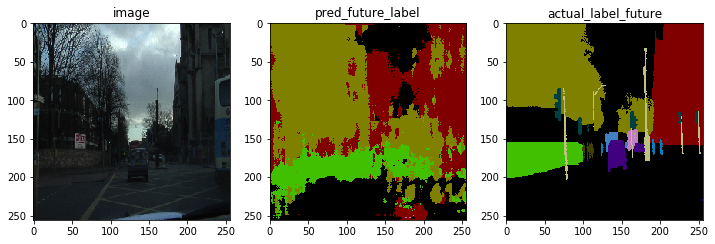

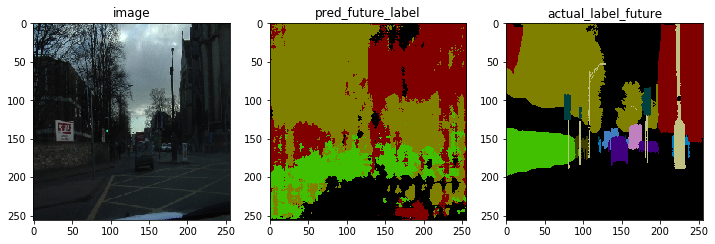

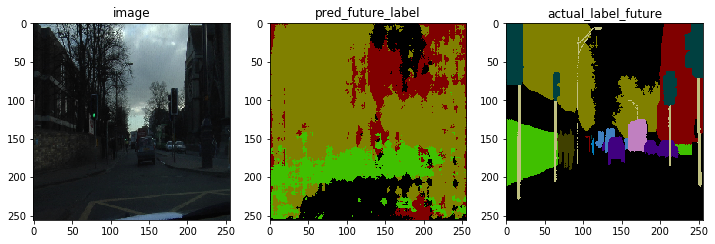

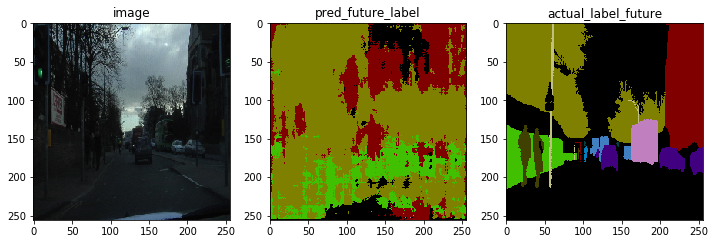

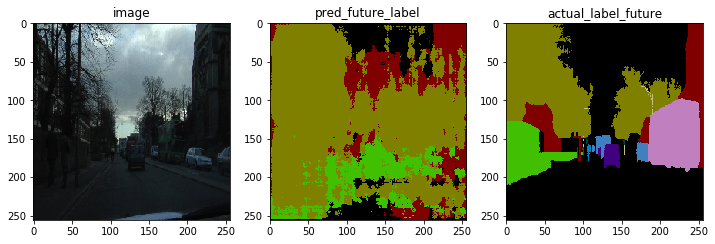

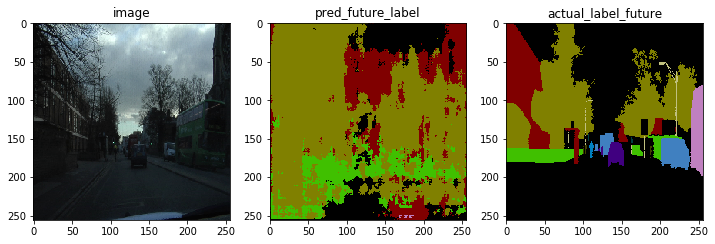

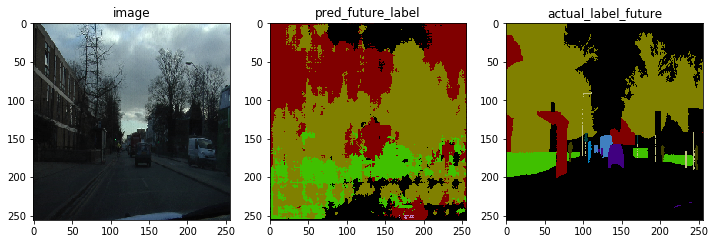

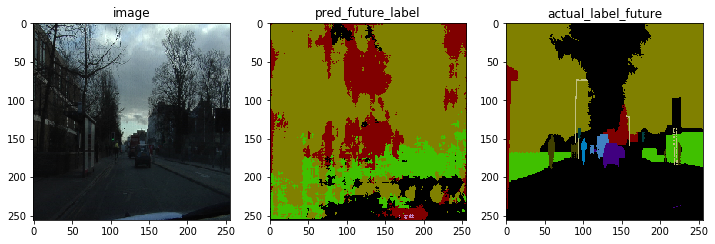

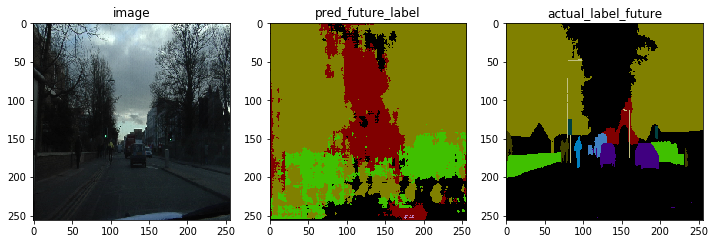

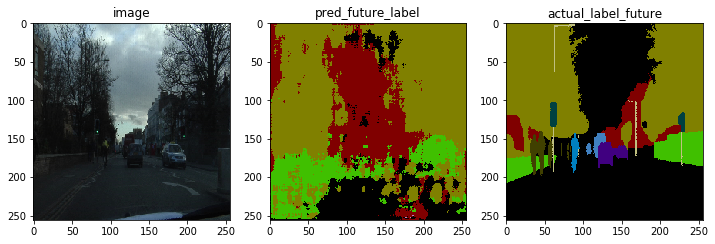

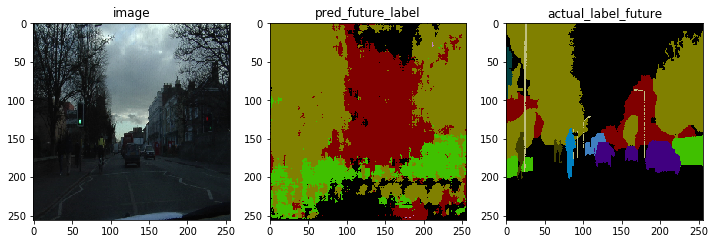

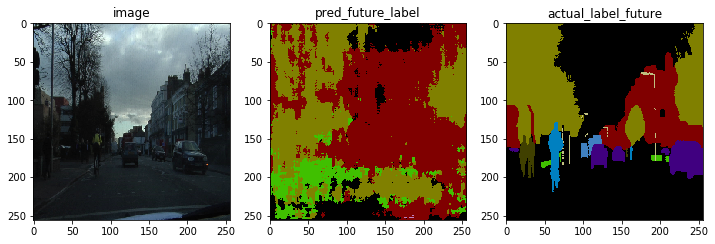

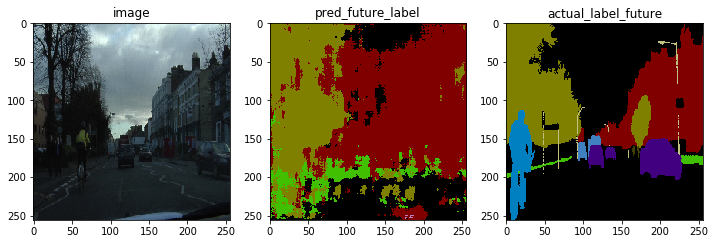

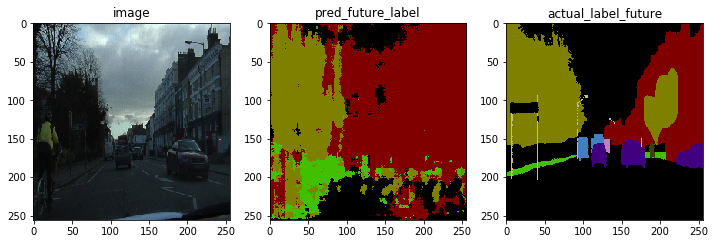

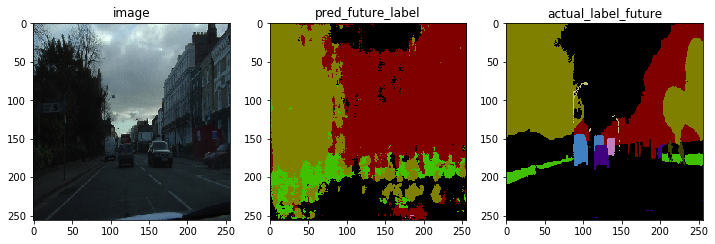

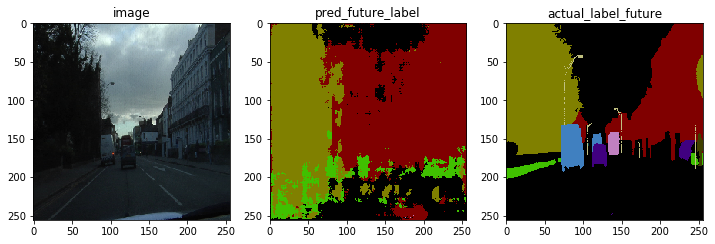

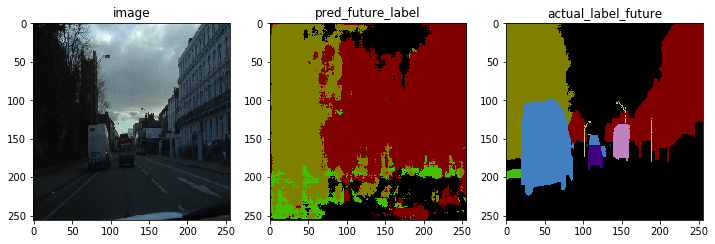

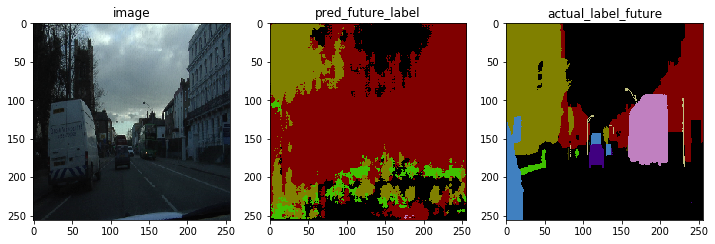

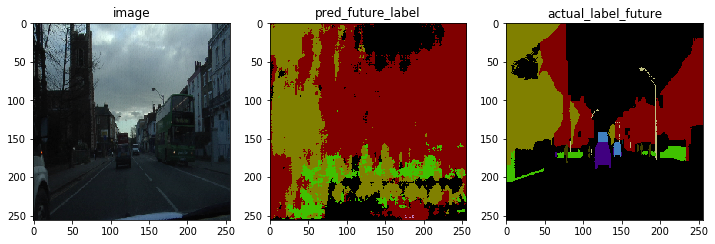

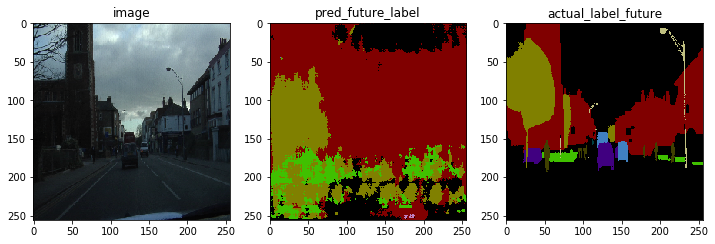

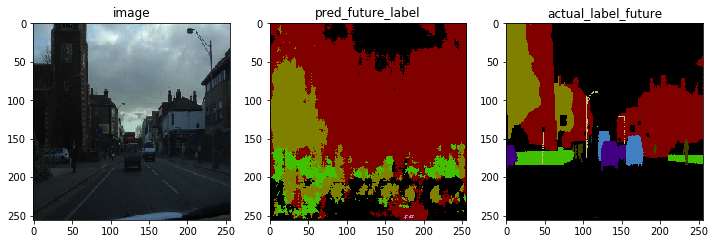

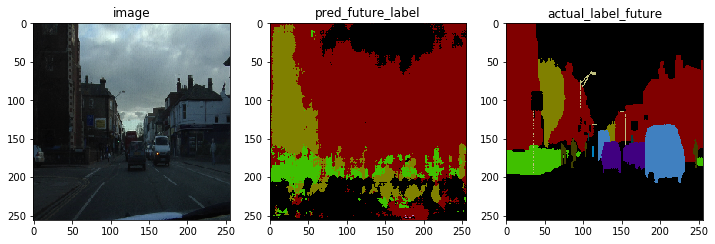

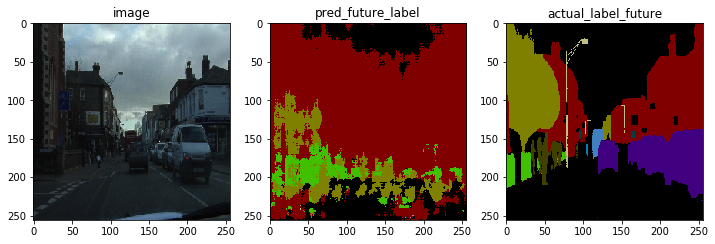

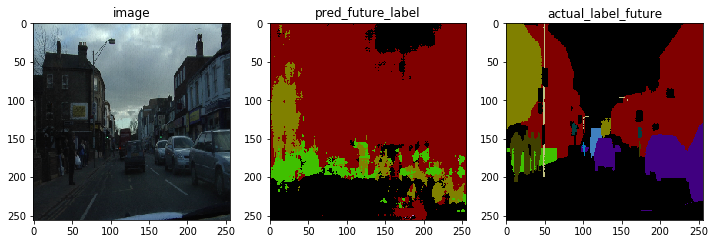

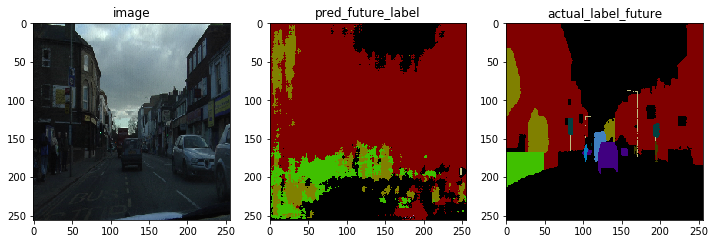

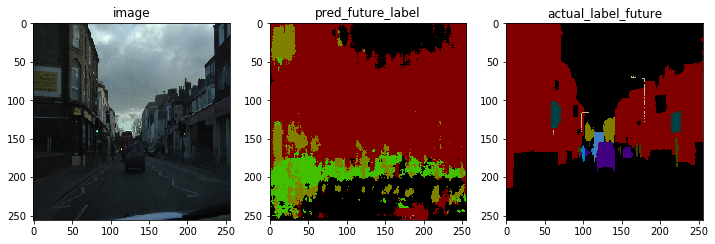

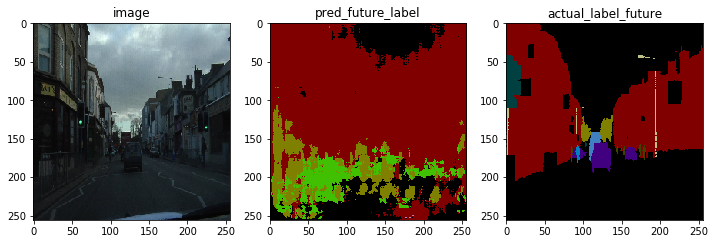

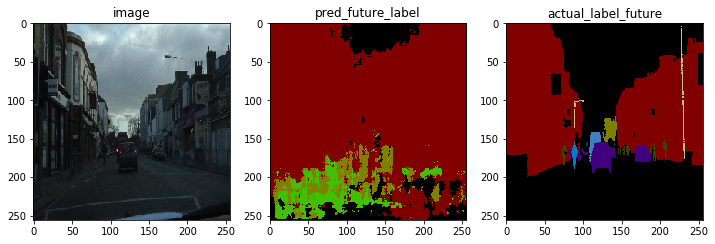

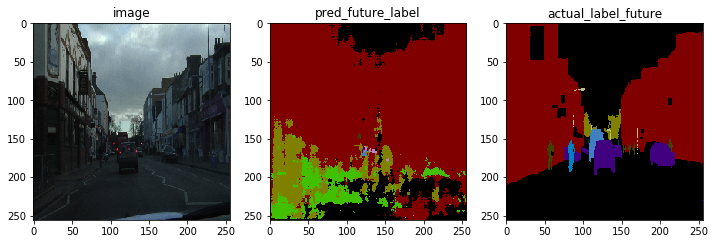

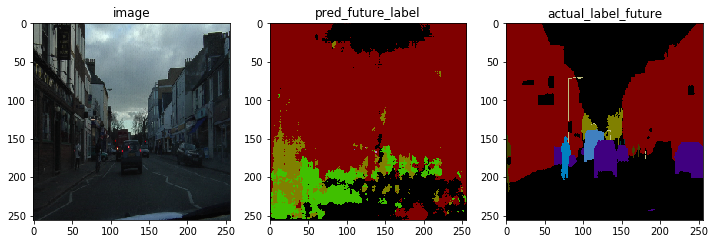

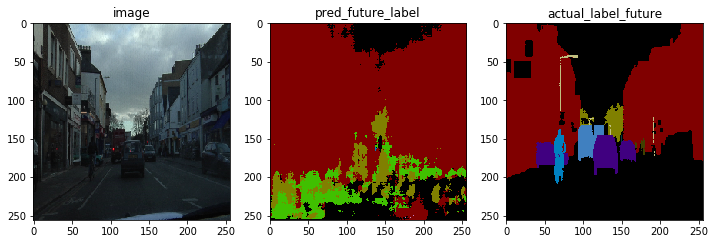

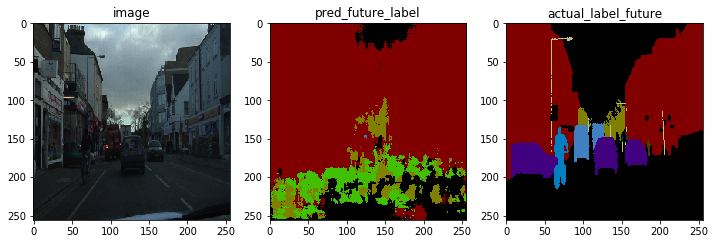

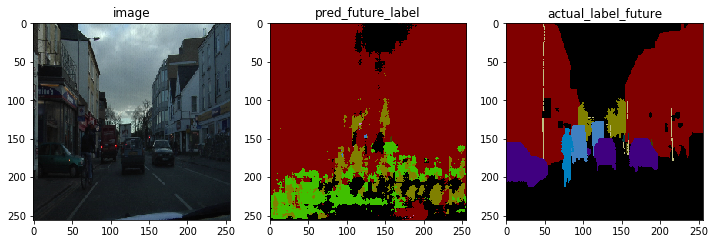

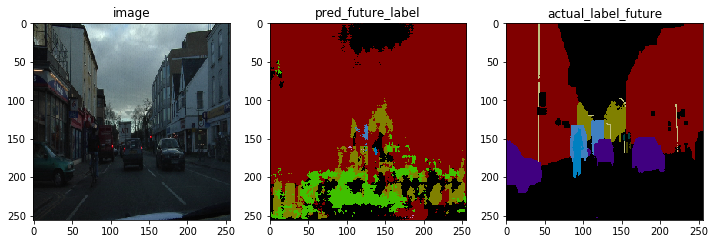

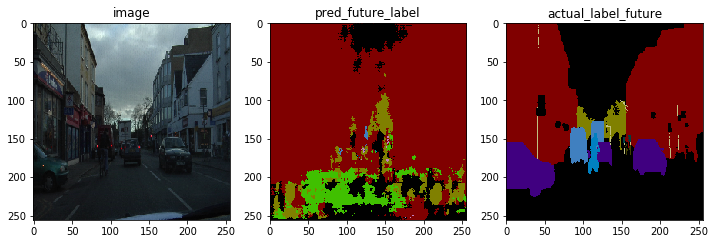

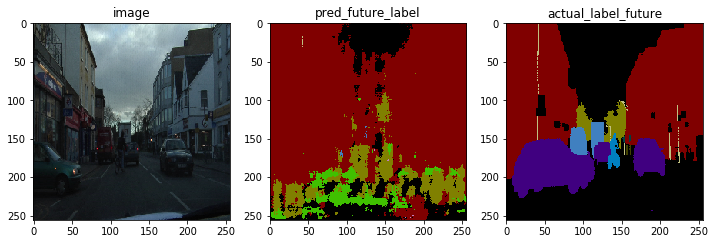

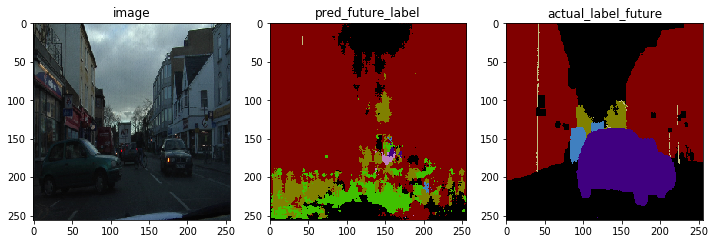

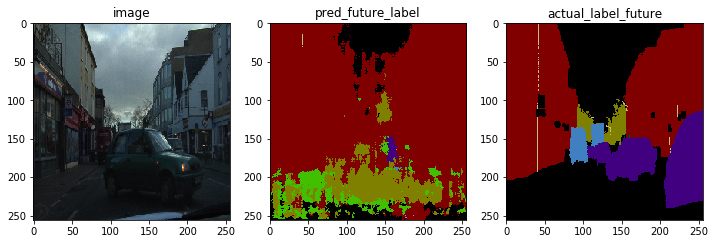

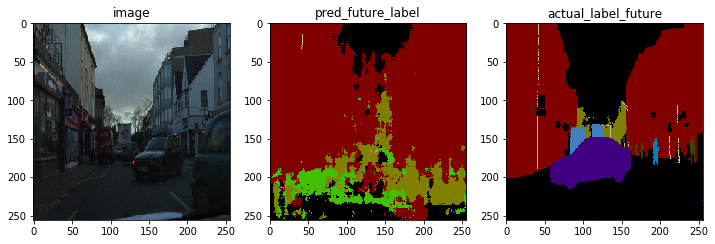

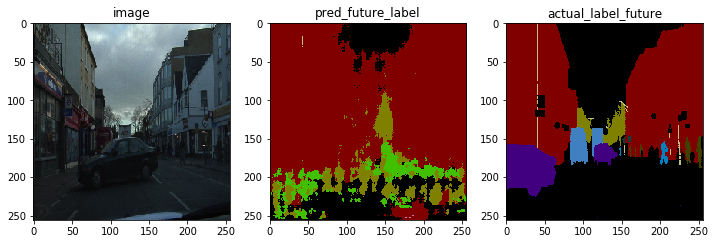

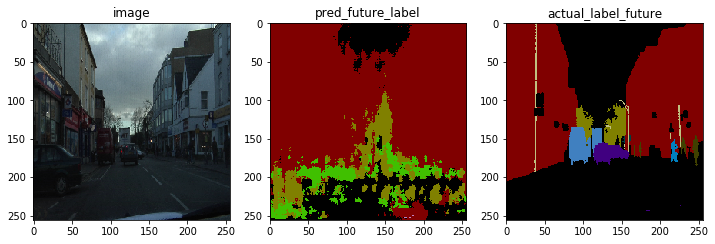

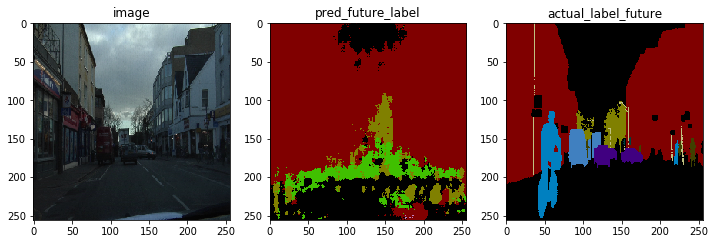

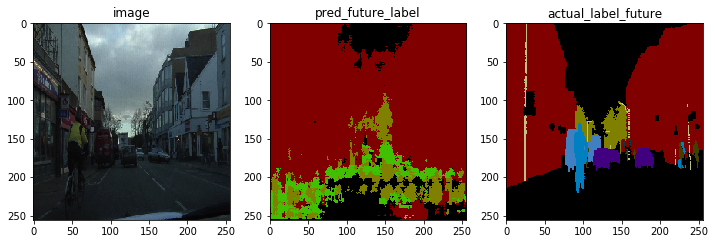

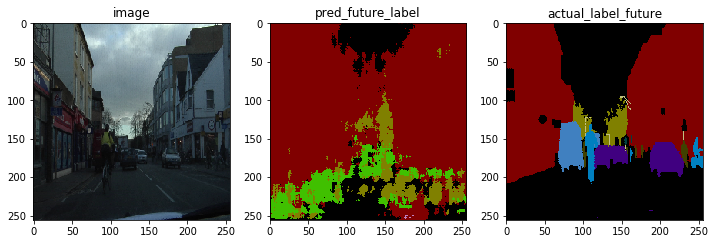

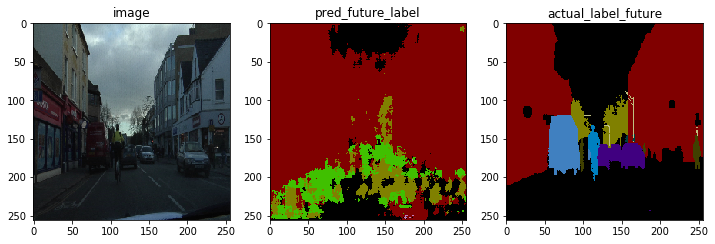

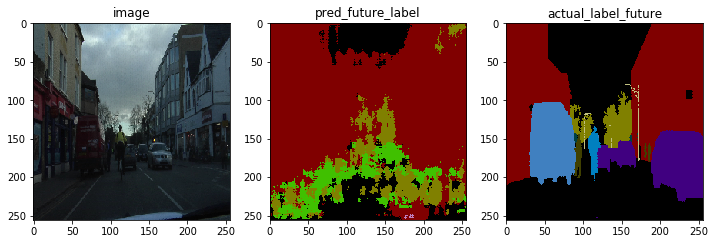

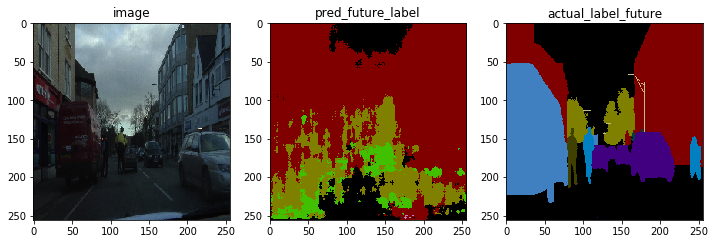

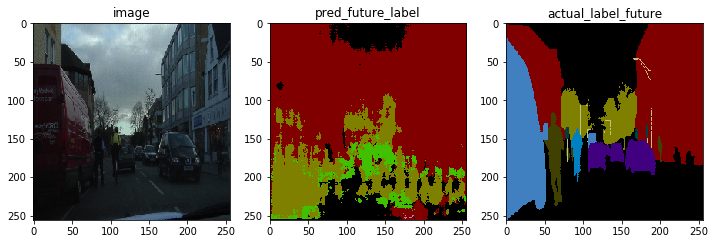

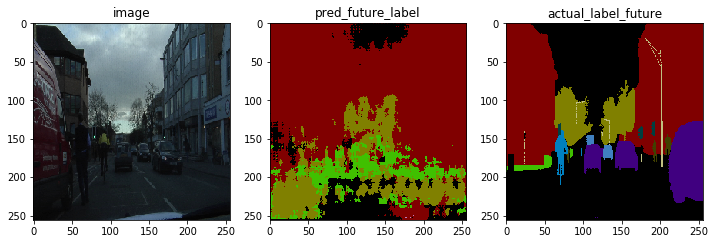

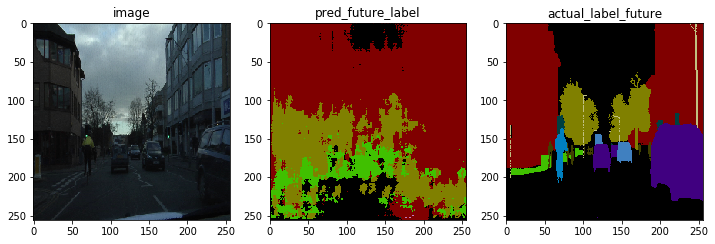

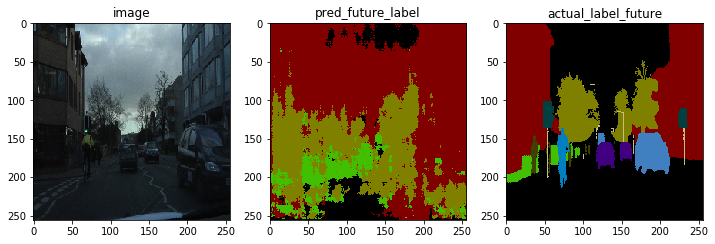

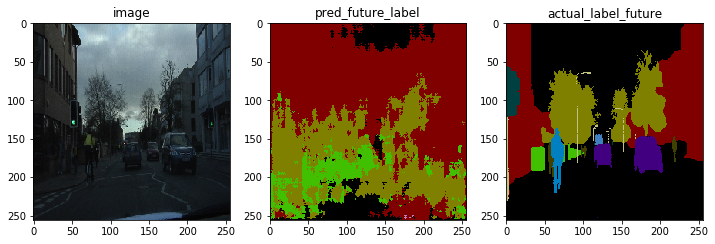

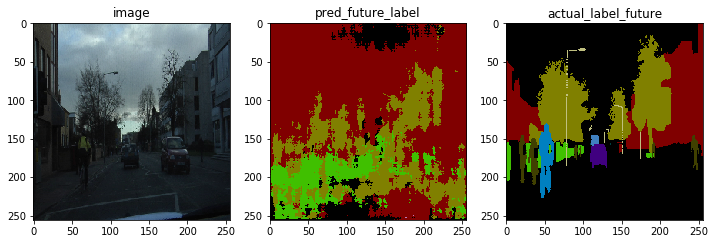

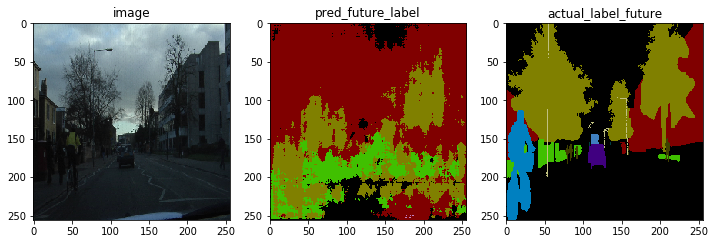

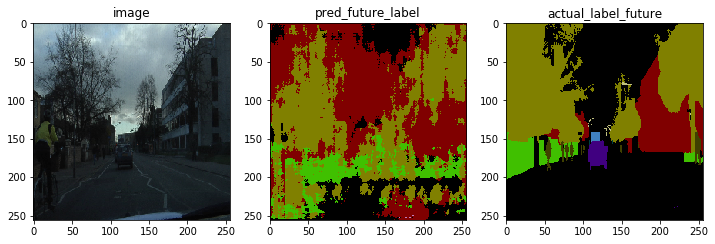

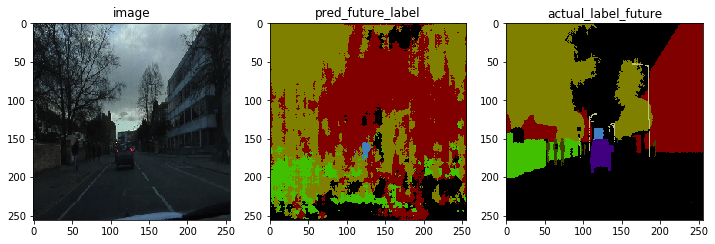

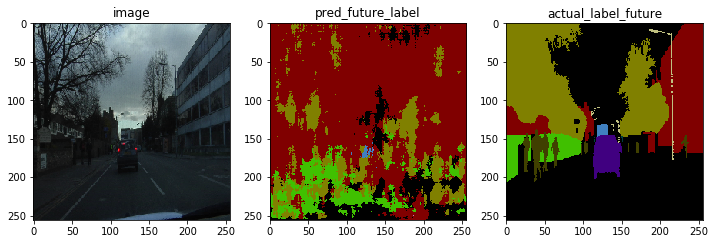

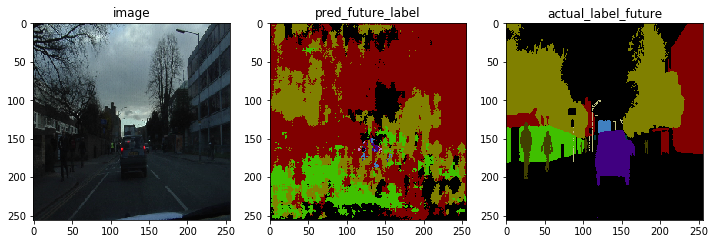

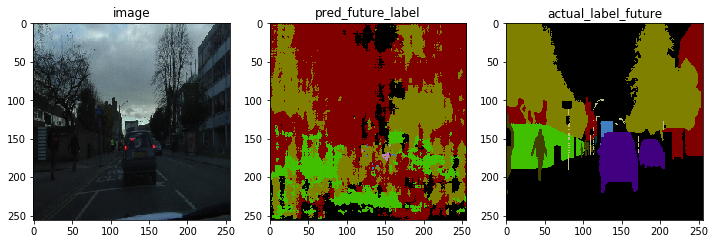

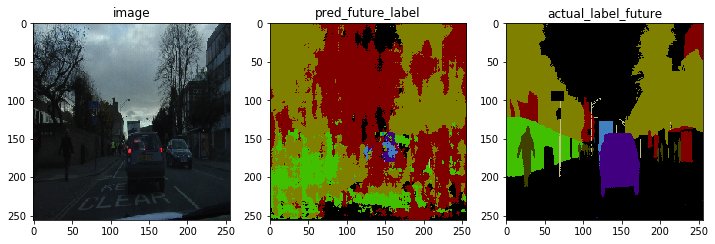

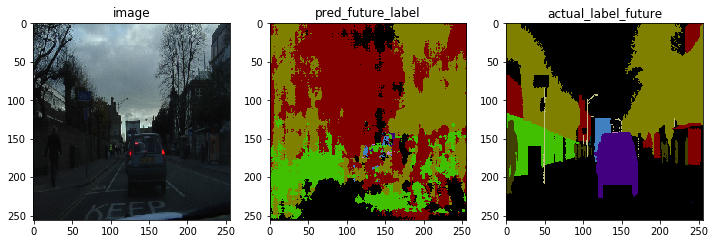

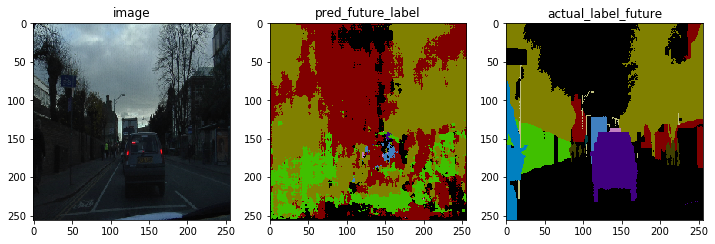

In [ ]:
model = densenet(nb_classes=nb_classes,img_dim=(256,256,3),growth_rate=16)
model.load_weights("models/Timestep1Epoch130.h5")
x , x_f , l_f = next(proc.frame2futurelabel_train_datagen(size=(256,256) , batch_size = 80 , time_step = 1 , normalise = True))

    
for i in range(78):
    image , image_future , label_future = x[i] , x_f[i] , l_f[i]
    image=np.array([image])
    image_future=np.array([image_future])
    label_future = np.array([label_future])
    pred_future = model.predict(image)
    pred_future_classm = np.argmax(pred_future[0] , axis = -1)
    pred_future_label = proc.class2image(pred_future_classm)

    label_classm = np.argmax(label_future[0] , axis = -1)
    label_label = proc.class2image(label_classm)

    image = (image[0] * 255).astype(np.uint8)
    image_future = (image_future[0] * 255).astype(np.uint8)   

    figure = plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.title("pred_future_label")
    #     image1=cv2.addWeighted(image,0.7,pred_future_label,0.3,0)
    plt.imshow(pred_future_label)
    plt.subplot(1,3,3)
    plt.title("actual_label_future")
    #     image2=cv2.addWeighted(image_future,0.7,pred_future_label,0.3,0)
    plt.imshow(label_label)
    plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_295 (Conv2D)             (None, 256, 256, 48) 1344        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_289 (BatchN (None, 256, 256, 48) 192         conv2d_295[0][0]                 
__________________________________________________________________________________________________
activation_289 (Activation)     (None, 256, 256, 48) 0           batch_normalization_289[0][0]    
__________________________________________________________________________________________________
conv2d_296

/home/rajat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/1
78/78 [==============================] - 41s 522ms/step - loss: 5.8161 - jaccard_distance: 1.2123
Loss : [5.816053891793276]  Jaccard Distance : [1.21234729886055]


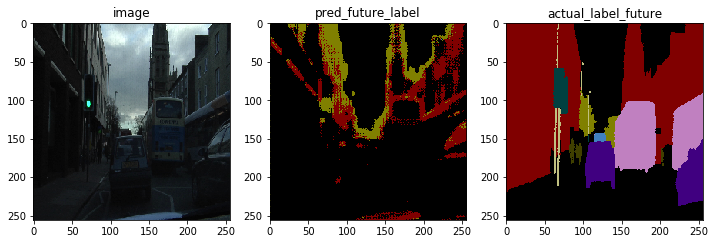

In [9]:
epochs=1
model = densenet(nb_classes=nb_classes,img_dim=(256,256,3),growth_rate=16)
image = None
image_future = None
label_future = None
# model.load_weights("models/newDensenetEpoch100.h5")

for e in range(1,epochs+1):
    for x , x_f , l_f in proc.frame2futurelabel_train_datagen(size=(256,256) , batch_size = 80 , time_step = 2 , normalise = True):
        image , image_future , label_future = x[:1] , x_f[:1] , l_f[:1]
        history = model.fit(x, l_f, batch_size=5, epochs=1,verbose=1, class_weight=class_weights) 
        print("Loss :",history.history['loss'] , " Jaccard Distance :", history.history['jaccard_distance'])
        
    if(e%10==0):
        model.save_weights("model_timestep1/Timestep1Epoch{}.h5".format(e))
    
    
    pred_future = model.predict(image)
    pred_future_classm = np.argmax(pred_future[0] , axis = -1)
    pred_future_label = proc.class2image(pred_future_classm)
    
    label_classm = np.argmax(label_future[0] , axis = -1)
    label_label = proc.class2image(label_classm)
    
    image = (image[0] * 255).astype(np.uint8)
    image_future = (image_future[0] * 255).astype(np.uint8)   

    figure = plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.title("pred_future_label")
#     image1=cv2.addWeighted(image,0.7,pred_future_label,0.3,0)
    plt.imshow(pred_future_label)
    plt.subplot(1,3,3)
    plt.title("actual_label_future")
#     image2=cv2.addWeighted(image_future,0.7,pred_future_label,0.3,0)
    plt.imshow(label_label)
    plt.show()